<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>DRAFT: Coadd Recreation</b> <br>
Contact author(s): Melissa Graham <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: intermediate <br>

In [1]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** Recreate a Coadded image from a subset of the input calexps.

**Skills:** Use of pipetasks for image coaddition. Creating and writing to Butler collections. Properties of deepCoadds.

**LSST Data Products:** deepCoadd, calexp

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:** Originally developed by Melissa Graham and Clare Saunders.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-1.lsst.io">dp0-1.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook shows how to retrieve information about the individual images that contributed to a deepCoadd, and how to make a new Coadded image using only a subset of the inputs.

In the past you might have used iraf's imcombine, or Astromatics's SWarp, to coadd images.
This notebook demonstrates the appropriate methods for coadding LSST images with the LSST Science Pipelines.

Science applications of coadding a subsets of LSST images includes searching for faint, slowly-evolving transients or variables (e.g.,, coadding images by season), using the effects of differential chromatic refraction (e.g., coadding images in bins of airmass), or perhaps searching for low surface brightness features (e.g., coadding only dark-time images with the faintest sky backgrounds).

### 1.1 Package Imports

_Provide explanation or external links to package documentation, where appropriate._

In [2]:
# standard python packages for numerical processing, plotting, and databases
import time
import getpass
import numpy as np

import matplotlib
font = {'size' : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

import pandas
pandas.set_option('display.max_rows', 1000)

# astropy package for time unit conversions
from astropy.time import Time

# lsst packages for data access and display
import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

# import lsst.daf.butler as dafButler
from lsst.daf.butler import Butler, DatasetType, CollectionType

# lsst packages for executing pipeline tasks
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, TaskDef, Instrument

### 1.2 Set Up

In [3]:
repo = 'dp02'
collection = '2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step_all'

Known issue: it is OK to ignore a pink-window message saying "WARNING: version mismatch between CFITSIO header (v4.000999999999999) and linked library (v4.01)."

In [4]:
butler = Butler(repo, collections=collection)

Display all the deepCoadd datasetTypes available via our butler.

In [5]:
for x in sorted(butler.registry.queryDatasetTypes()):
    temp = str(x)
    if temp.find('deepCoadd') > -1:
        print(x)
    del temp

DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_calexp', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_calexp_background', {band, skymap, tract, patch}, Background)
DatasetType('deepCoadd_dcr_ddec_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap)
DatasetType('deepCoadd_dcr_ddec_map_weighted_mean', {band, skymap, tract}, HealSparseMap)
DatasetType('deepCoadd_dcr_dra_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap)
DatasetType('deepCoadd_dcr_dra_map_weighted_mean', {band, skymap, tract}, HealSparseMap)
DatasetType('deepCoadd_dcr_e1_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap)
DatasetType('deepCoadd_dcr_e1_map_weighted_mean', {band, skymap, tract}, HealSparseMap)
DatasetType('deepCoadd_dcr_e2_consolidated_map_weighted_mean', {band, skymap}, HealSparseMap)
DatasetType('deepCoadd_dcr_e2_map_weighted_mean', {band, skymap, tract}, HealSparseMap)
DatasetType('deepCoadd_deblendedCatalog', 

## 2. Identify the visits to combine

### 2.1. Start with a deepCoadd

Identify and retrieve the deepCoadd to be recreated.

For this example, the coordinates of a known galaxy cluster are used.

It takes 4-5 seconds to retrieve a single deepCoadd from the butler.

In [6]:
%%time

my_ra_deg = 55.745834
my_dec_deg = -32.269167

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees,
                                       my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': 'i', 'tract': my_tract, 
             'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=my_dataId)

# clean up
del my_ra_deg, my_dec_deg, my_spherePoint, tract

My tract and patch:  4431 17
CPU times: user 3.29 s, sys: 1.07 s, total: 4.35 s
Wall time: 5.14 s


Uncomment the following cell to show the deepCoadd image.

In [7]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(my_deepCoadd.image)
# plt.gca().axis('off')

It is not necessary to know the bounding box for a deepCoadd in order to find all of the calexps that were used to assemble it.
But, if you want to learn more about the deepCoadd metadata, such as bounding box, corners, and the World Coordinate System (WCS), uncomment and execute the following cells.

In [8]:
# my_deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=my_dataId)
# print('bbox')
# print(my_deepCoadd_bbox.beginX, my_deepCoadd_bbox.beginY, 
#       my_deepCoadd_bbox.endX, my_deepCoadd_bbox.endY)

# print('')
# print('corners')
# print(my_deepCoadd_bbox.getCorners())

# print('')
# print('wcs')
# my_deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=my_dataId)
# print(my_deepCoadd_wcs)

# # clean up
# del my_deepCoadd_bbox, my_deepCoadd_wcs

### 2.2. Retrieve the deepCoadd's input visits

It takes 2-3 seconds to retrieve the coadd inputs from the butler.

In [9]:
%%time

my_coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", my_dataId)

CPU times: user 1.76 s, sys: 982 ms, total: 2.75 s
Wall time: 2.38 s


The coadd inputs table of visits can be displayed as an astropy table, if you want to view the contents.

In [10]:
# my_coadd_inputs.visits.asAstropy()

The length of this table, 161, indicates that 161 separate visits contributed to this deepCoadd.

In [11]:
len(my_coadd_inputs.visits)

161

It is not necessary to make a list of all deepCoadd input visit ids, but if you wanted to, you could do it and display it like this.

In [12]:
# my_coadd_visits = my_coadd_inputs.visits['id']
# my_coadd_visits

### 2.3. Get metadata for the input visits

Retrieve the modified julian date (MJD) of the input visits from the visitTable.

First, get the entire visit table.

In [13]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))

In [14]:
# visitTableRef

In [15]:
visitTable = butler.get(visitTableRef[0])

In [16]:
# visitTable

The fact that the id column for both the my_coadd_inputs.vists table and the visitTable is the visit number (visit id) makes it simple to retrieve the MJDs of our coadd input visits.

In [17]:
my_coadd_visits_mjds = visitTable.loc[my_coadd_inputs.visits['id']]['expMidptMJD']

These list of MJDs have 161 elements, for the 161 separate visits contributed to this deepCoadd.

In [18]:
len(my_coadd_visits_mjds)

161

### 2.4. Identify input visits to recreate Coadd

Identify input visits with MJD between 60925 abd 60955.

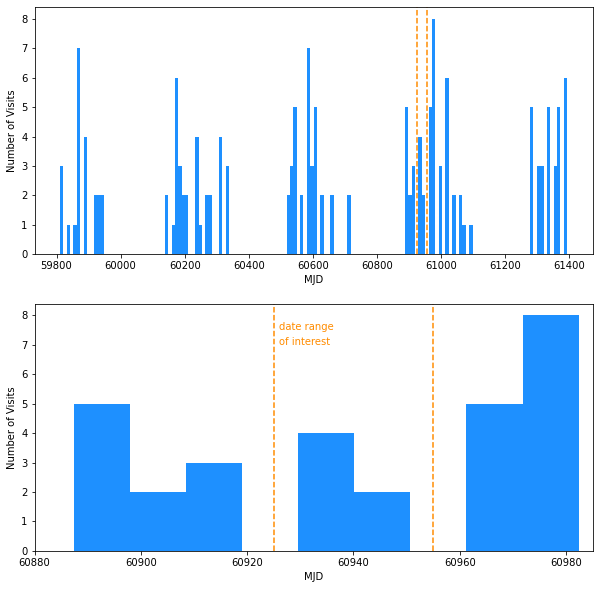

In [19]:
range_start = 60925
range_end = 60955

fig, ax = plt.subplots( 2, figsize=(10,10) )

ax[0].hist(my_coadd_visits_mjds, bins=150, color='dodgerblue')
ax[0].set_xlabel('MJD')
ax[0].set_ylabel('Number of Visits')
ax[0].axvline(range_start, ls='dashed', color='darkorange')
ax[0].axvline(range_end, ls='dashed', color='darkorange')

ax[1].hist(my_coadd_visits_mjds, bins=150, color='dodgerblue')
ax[1].set_xlabel('MJD')
ax[1].set_ylabel('Number of Visits')
ax[1].set_xlim([60880,60985])
ax[1].axvline(range_start, ls='dashed', color='darkorange')
ax[1].axvline(range_end, ls='dashed', color='darkorange')
ax[1].text(range_start+1, 7.5, 'date range', color='darkorange')
ax[1].text(range_start+1, 7.0, 'of interest', color='darkorange')

plt.show()

From the lower plot above, there are 6 visits in the data range of interest.

Put this list of visits into a string, formatted as a tuple (within round brackets and separated by commas) for use in a query below.

In [20]:
my_range = np.array((my_coadd_visits_mjds > range_start) & 
                    (my_coadd_visits_mjds < range_end))

my_visits = my_coadd_inputs.visits[my_range]

my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)

(919515,924057,924085,924086,929477,930353)


Confirm that the intermediate data products which we will need in Section 3, the `deepCoadd_directWarp`, exist.

In [23]:
for x in sorted(butler.registry.queryDatasetTypes()):
    temp = str(x)
    if temp.find('directWarp') > -1:
        print(x)
    del temp

DatasetType('deepCoadd_directWarp', {band, instrument, skymap, physical_filter, tract, visit_system, patch, visit}, ExposureF)


In [22]:
checkwarp_dataId = {'tract': 4431, 'patch': 17, 'skymap': 'DC2', 'visit': '919515'}
checkwarp_deepCoadd = butler.get('deepCoadd_directWarp', dataId=checkwarp_dataId)

LookupError: Dataset deepCoadd_directWarp with data ID {instrument: 'LSSTCam-imSim', skymap: 'DC2', tract: 4431, patch: 17, visit: 919515} could not be found in collections [2.2i/runs/DP0.2/v23_0_2/PREOPS-905/step_all].

In [24]:
del checkwarp_dataId, checkwarp_deepCoadd

NameError: name 'checkwarp_deepCoadd' is not defined

OK, our visit of interest has no directWarp; are there any?

In [28]:
datasetRefs = butler.registry.queryDatasets(datasetType='deepCoadd_directWarp', 
                                     collections=collection)

for i, ref in enumerate(datasetRefs):
    print(i)
    print(ref.dataId.full)
    print(ref.dataId)
    print(ref.dataId['band'])
    print(' ')
    if i > 2:
        break

No there are not...

In [29]:
del datasetRefs

### 2.5. Exercise for the learner

Use airmass constraints instead of MJD to identify the subset of visits to coadd.

> Hint: start with 
> `my_coadd_visits_airmass = visitTable.loc[my_coadd_inputs.visits['id']]['airmass']`

## 3. Create a coadd with the subset of visits 

### 3.1. Name a new butler collection for output

**Important:** Use the convention `u/[Your User Name]/coadd_recreation_nb` to set up a new output collection for this tutorial.

Recall that RSP user names are the same as GitHub user names, because GitHub accounts are used to authorize access to the RSP.

In [ ]:
my_username = getpass.getuser()
my_outputCollection = 'u/'+my_username+'/coadd_recreation_nb'
print(my_outputCollection)

Does this output collection already exist? If nothing is printed below this cell, the output collection does not already exist.

In [ ]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

#### 3.1.1. To delete these collection you have already made

Instantiate a temporary butler with write permissions and remove the collection by name.

In [ ]:
for c in sorted(butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print('Found: ', c)
        try:
            tmpButler = Butler(repo, writeable=True)
            tmpButler.registry.removeCollection(c)
            print('Removed: ', c)
        except:
            print('Could not remove: ', c)
        del tmpButler

<br>
Remove the originally instantiated butler, because below, a simple butler is created and used thereafter.

In [ ]:
del butler

### 3.2. Set up a simple butler with the new output collection

> **When DM-35153 is fixed, this will be possible.**

In [ ]:
# simpleButler = SimplePipelineExecutor.prep_butler(repo, inputs=[collection],
#                                                   output=my_outputCollection)

> **For now, this is the workaround.** If this goes to production, explain every command with a comment.

In [ ]:
outputRun = f"{my_outputCollection}/{Instrument.makeCollectionTimestamp()}"

tmpButler = Butler(repo, writeable=True)
tmpButler.registry.registerCollection(outputRun, CollectionType.RUN)
tmpButler.registry.registerCollection(my_outputCollection, CollectionType.CHAINED)

collections = [collection]
collections.insert(0, outputRun)

tmpButler.registry.setCollectionChain(my_outputCollection, collections)

simpleButler = Butler(butler=tmpButler, collections=[my_outputCollection], run=outputRun)

Check that the subdirectory of the newly created output collection is first in the list.

Note that the collection has had a timestamp added.

In [ ]:
simpleButler.registry.getCollectionChain(my_outputCollection)

Check on all the related butler output collections that currently exist.

In [ ]:
for c in sorted(simpleButler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print('Found: ', c)

### 3.3. Select the assembleCoadd task from the larger Data Release pipeline

> **TO DO: Add more description of pipeline tasks here.**

This method for creating the `assembleCoaddPipeline` task in a notebook is not intuitive, but is preferred because it gives the user all of the configuration settings for the instrument automatically, and because it most closely replicates the command-line syntax.

In [ ]:
assembleCoaddPipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml#assembleCoadd')

The other tasks available are listed in the `yaml` file. 
To see the other tasks, first open a new terminal (click the blue + button at upper left and then select terminal).
Then create a Rubin Observatory environment, navigate to the DRP.yaml file, and view its contents with:
> `setup lsst_distrib` <br>
> `cd ${PIPE_TASKS_DIR}/pipelines/`<br>
> `more DRP.yaml`

When attempting to use `more` on the `yaml` file, a redirect to its true location might be returned. If so, follow the path given.

### 3.4. Optional: rename your output Coadd

This can only be done by registering a new `DatasetType`. If this step is skipped, the output will be named deepCoadd (whether or enough images are being combined to be considered "deep").

> **TO DO:** Verify this works.
> **Help Question:** Why is a whole new dataset *type* required? <br>
> **Help Question:** If I wanted to make 5 new Coadds that were stacks of 5 separate weeks of images would I do this 5 times?

The following cell does this series of actions.
* -- Create a DeferredDatasetHandle which can later retrieve a dataset, after an immediate registry lookup.
* -- Use the new DeferredDatasetHandle to instantiate your new DatasetType.
* -- Register this new DatasetType with your simpleButler.
* -- Update the configuration for the pipeline you created to include a connection to your new DatasetType.

The following cell has no output.

In [ ]:
# deferred = simpleButler.getDeferred('deepCoadd', dataId=my_dataId)

# newDatasetType = DatasetType("myCoadd1", dimensions=deferred.ref.dimensions,
#                              storageClass=deferred.ref.datasetType.storageClass)

# simpleButler.registry.registerDatasetType(newDatasetType)

# assembleCoaddPipeline.addConfigOverride("assembleCoadd", "connections.coaddExposure", "myCoadd1")

> **TO DO: Add a link to documentation about configuration options here.**

Other configurations can be set using the same command, with the format `addConfigOverride(<taskName>, <configName>, <configValue>)`.

For example, `assembleCoaddPipeline.addConfigOverride("assembleCoadd", "doFilterMorphological", False)`.

### 3.5. Create the full query string

Above, the visits to be recombined were stored in `my_visits_tupleString`. 

Below, the full query string is built to include the patch being recreated.

> **Help Question:** Why is the skymap included in the where query? 

In [ ]:
queryString = f"patch = {my_patch} AND visit in {my_visits_tupleString} AND skymap = 'DC2'" 
print(queryString)

### 3.6. Use the Simple Pipeline Executor to assemble the Coadd

Set up the Simple Pipeline Executor.

> **Help Question:** Where is the documentation for SimplePipelineExecutor? Imported from lsst.ctrl.mpexec but not listed at https://pipelines.lsst.io/modules/lsst.ctrl.mpexec/index.html

In [ ]:
# SimplePipelineExecutor.from_pipeline?

In [ ]:
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

In [ ]:
list(simpleButler.registry.queryDataIds(dimensions=['band', 'instrument', 'skymap', 'physical_filter', 'tract', 'visit_system', 'patch', 'visit'],
                                  dataId={},
                                  where="patch = 17 AND visit in (919515,924057,924085,924086,929477,930353) AND skymap = 'DC2'",
                                  datasets=['deepCoadd_psfMatchedWarp', 'deepCoadd_directWarp', 'skyMap'],
                                  collections=['u/melissagraham/coadd_recreation_nb']))

In [ ]:
print(set(list(simpleButler.registry.queryDatasets('deepCoadd_directWarp', where=queryString))))
print(set(list(simpleButler.registry.queryDatasets('skyMap', where=queryString))))

Run the pipeline. This takes about XX minutes for 6 visits.

In [ ]:
%%time
quanta = spe.run()

In [ ]:
quanta

In [ ]:
quanta[0].outputs

Try the other method. Still will not run.

In [ ]:
# from lsst.pipe.tasks import assembleCoadd

In [ ]:
# config = assembleCoadd.CompareWarpAssembleCoaddTask.ConfigClass()
# #config.connections.coaddExposure = "myCoadd2"
# tasks = [TaskDef(label="assembleCoadd", taskClass=assembleCoadd.CompareWarpAssembleCoaddTask, config=config)]

In [ ]:
# queryString = f"patch = {my_patch} AND visit in {my_visits_tupleString} AND skymap = 'DC2'" 

In [ ]:
# spe2 = SimplePipelineExecutor.from_pipeline(tasks, where=queryString, butler=simpleButler)

In [ ]:
# %%time
# quanta2 = spe2.run()

To be added: show new coadded image, show inputs of new coadded image are only what we specified, then run source detection on new coadded image, and compare with the original deepCoadd.

<br>
<br>
<br>
<br>
<br>
<br>


# Earlier attempts are below. 

<br>
<br>

### 3.1. Try using the pipe task assembleCoadd

https://pipelines.lsst.io/modules/lsst.pipe.tasks/index.html#lsst-pipe-tasks

https://pipelines.lsst.io/modules/lsst.pipe.tasks/tasks/lsst.pipe.tasks.assembleCoadd.AssembleCoaddTask.html

In tutorial-notebooks/05_Intro_to_Source_Detection.ipynb, pipe tasks are used, follow that example.

Similar to NB 05, Jeff managed to use a couple of pipe.tasks for image differencing in https://github.com/rubin-dp0/delegate-contributions-dp01/blob/u/jcarlin/diff_im/diff_im/diff_im_test.ipynb

Yusra shows use of tasks and configs in https://github.com/LSSTScienceCollaborations/StackClubCourse/blob/master/Session02/IntroToDataProductsAndTasks.ipynb

From Yusra's NB, I'm trying to follow "Background Subtraction and Task Configuration" section in use of pipe task.

<br>

In [ ]:
from lsst.pipe.tasks.assembleCoadd import AssembleCoaddTask

In [ ]:
myConfig = AssembleCoaddTask.ConfigClass()

In [ ]:
# call the result year3
myConfig.coaddName = 'year3'

In [ ]:
# yes i only want to do selected visits
myConfig.doSelectVisits = True

In [ ]:
# the list of selected visits
myConfig.connections.selectedVisits = visit_list

What else do I need to specify in the config?

In [ ]:
myConfig

In [ ]:
myTask = AssembleCoaddTask(config=myConfig)

In [ ]:
# myTask?

In [ ]:
# help(myTask.run)

**To Figure Out**

1. The `run` method requires inputs.
I suspect it is insufficient to put the selected visits in the Config.
I need to pass a query or dataIds for the inputs I want to coadd.

2. I'm not sure if I should use `.run` or `.runDataRef`. 
The latter's description is "Assemble a coadd from a set of Warps." which is actually all I want to do.

In [ ]:
# result = myTask.run()

In [ ]:
# result = myTask.runDataRef()

In [ ]:
# result

In [ ]:
# help(assembleCoaddTask)

In [ ]:
del myConfig, myTask

<br>
<br>

### 3.2. Try following Nate's recommended way

follow the steps by K-T in:

https://community.lsst.org/t/figuring-out-how-to-call-the-python-api/6432/11

as recommended by Nate in this post about recreating coadds:

https://community.lsst.org/t/coadding-dp0-calexps-from-different-detectors-for-the-same-deepcoadd/6436/8

Nate Lust also recommended to follow:
 * https://pipelines.lsst.io/v/weekly/modules/lsst.pipe.base/creating-a-pipeline.html
 * https://pipelines.lsst.io/v/weekly/modules/lsst.pipe.base/creating-a-pipelinetask.html


**To Figure Out**:
1. what config do i need to set?
2. where am i even telling it to assemble a coadd from the inputs? how does this pipeline know what to do?

In [ ]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

repo and input collection are already defined

In [ ]:
print(repo)
print(collection)

#### create a collection just for me

https://pipelines.lsst.io/py-api/lsst.daf.butler.Registry.html#lsst.daf.butler.Registry.registerCollection

In [ ]:
output_collection = 'u/MelissaGraham/coadd_recreation_nb'

In [ ]:
# butler.registry.registerCollection(output_collection, type='RUN', doc='made for a tutorial')

already done, so it appears in this list

In [ ]:
# for c in sorted(butler.registry.queryCollections()):
#     print(c)

#### create the data query for my visits and detectors

I learned what this should look like from https://pipelines.lsst.io/getting-started/coaddition.html

In [ ]:
data_query = 'visit in ('+visit_list+')'

In [ ]:
print(data_query)

#### set pipeline config

unsure what is needed or how to figure it out

label, key, and value are not needed? because we can use defaults?

In [ ]:
### Use defaults
# label = 
# key = 
# value = 

#### set up and run

but where am i telling this pipeline just to execute the coadd step?

In [ ]:
butler = SimplePipelineExecutor.prep_butler(repo,
                                            inputs=['2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'],
                                            output='u/MelissaGraham/coadd_recreation_nb')

In [ ]:
pipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml')

In [ ]:
pipeline.addInstrument('LSSTCam-imSim')

In [ ]:
# pipeline.addConfigOverride(label, key, value)

comment out below, not sure what it's doing yet

In [ ]:
# spe = SimplePipelineExecutor.from_pipeline(pipeline, where=data_query, butler=butler)
# quanta = spe.run(True)